## Implementation of CART from Scratch & Predict of tip value using Tips dataset - Idriss Khattabi

In [2]:
# import packages
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import treePlotter as tpl

### load Tips dataset and explore and visualize the data :

In [3]:
# Load tips's dataSet
dataSet = sns.load_dataset("tips")

# dataset infos
print("dataset shape : ", dataSet.shape)
print("iris dataset labels : ", list(dataSet.columns))
dataSet.head()

dataset shape :  (244, 7)
iris dataset labels :  ['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
# get categorical features
categorical_columns = dataSet.select_dtypes(['category']).columns
# Convert categorical variables to numerical representation
for col in categorical_columns:
    dataSet[col] = dataSet[col].cat.codes

dataSet.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,1,1,3,1,2
1,10.34,1.66,0,1,3,1,3
2,21.01,3.50,0,1,3,1,3
3,23.68,3.31,0,1,3,1,2
4,24.59,3.61,1,1,3,1,4


In [5]:
# create train & test sets

X = dataSet[["total_bill", "sex", "smoker", "day", "time", "size"]].values
Y = dataSet["tip"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Standardize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

sorted_columns_names = ["total_bill", "sex", "smoker", "day", "time", "size", "tip"]

#concatenate X with Y for training set and testing set, and convert theme to pandas DataFrame
trainingSet = pd.DataFrame(np.hstack((x_train, y_train.reshape(-1, 1))), columns=sorted_columns_names)
testingSet = pd.DataFrame(np.hstack((x_test, y_test.reshape(-1, 1))), columns=sorted_columns_names)

print(len(testingSet))
print(len(trainingSet))
trainingSet.head()

49
195


,total_bill,sex,smoker,day,time,size,tip
0,-0.793062,-0.731733,0.790569,0.225029,0.610933,-0.612141,2.72
1,0.463227,-0.731733,-1.264911,0.225029,0.610933,-0.612141,2.03
2,0.807307,-0.731733,-1.264911,-0.652584,0.610933,-0.612141,4.00
3,1.313709,-0.731733,0.790569,1.102642,0.610933,1.519421,4.50
4,-0.484419,-0.731733,0.790569,-1.530197,-1.636840,-0.612141,2.03


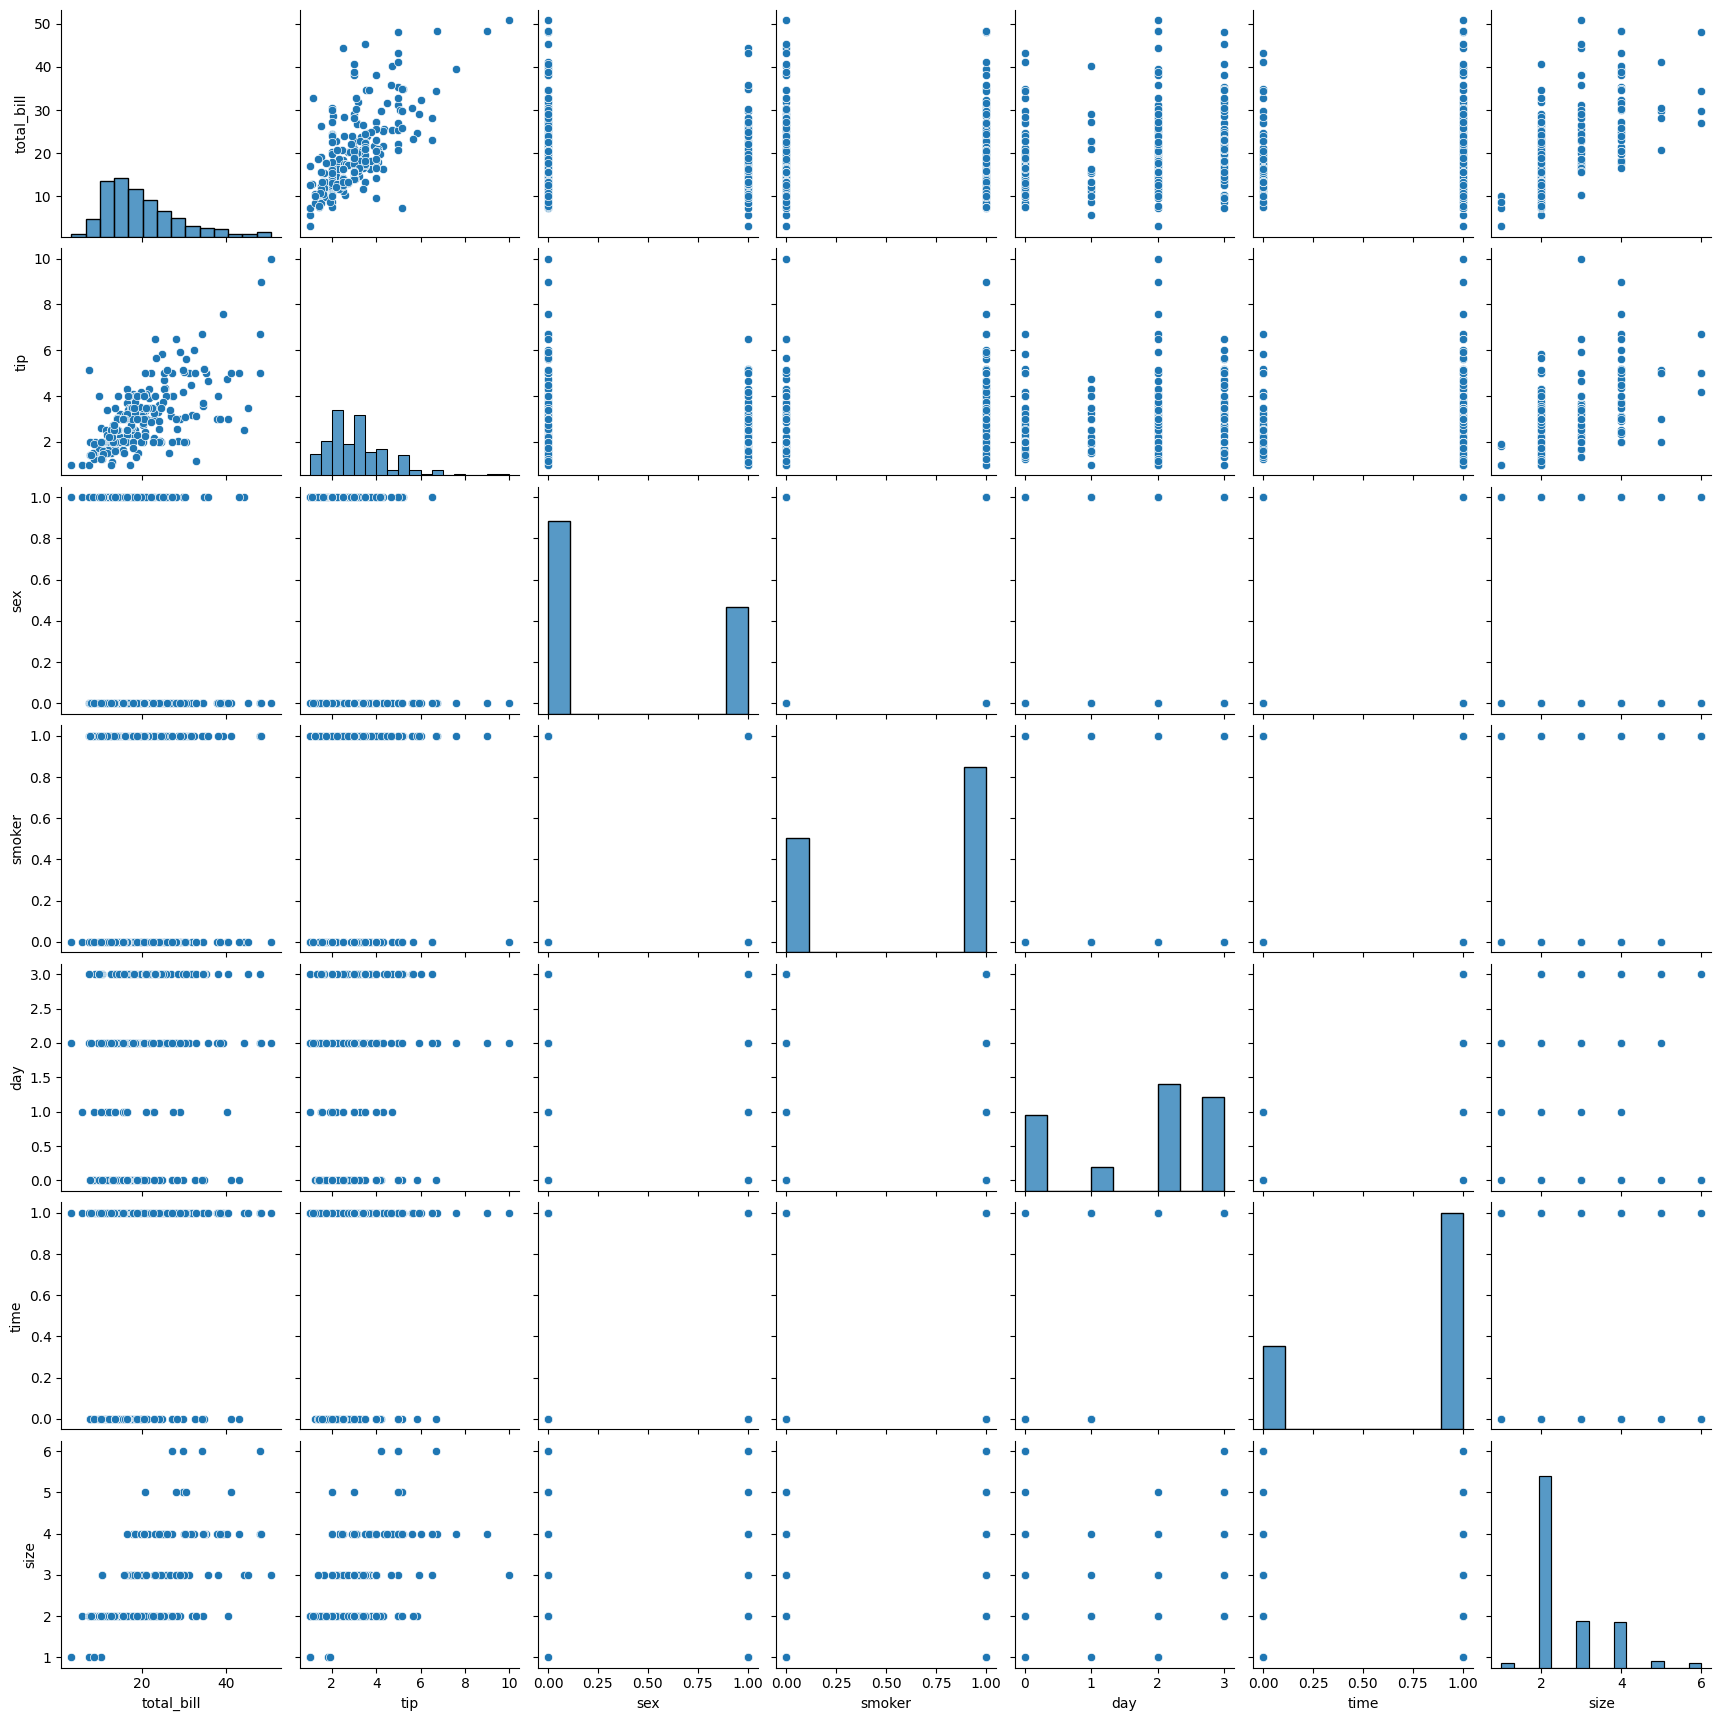

In [23]:
# scatter plot
sns.pairplot(dataSet)

### Define the CART functions

In [6]:
# spliting dataset according the threshold
# and each feature must have only two branchs
def split_data(feature, threshold, data):
    left_mask = data[feature] <= threshold
    right_mask = ~left_mask
    return data[left_mask], data[right_mask]

In [7]:
# finding the best threshold for spliting by calculating mean squared error (MSE)
# and choose threshold with the min mean squared error (MSE)
def find_best_split(data):
    features = data.columns[:-1]  # Exclude the target attribute ('tip')
    #print("Features:", features)
    best_feature, best_threshold, best_mse = None, None, float('inf')

    for feature in features:
        thresholds = data[feature].unique()
        for threshold in thresholds:
            left_data, right_data = split_data(feature, threshold, data)

            if len(left_data) == 0 or len(right_data) == 0:
                total_mse = float('inf')
            else:
                # Calculate MSE for both subsets
                left_mse = mean_squared_error(left_data['tip'], np.full_like(left_data['tip'], np.mean(left_data['tip'])))
                right_mse = mean_squared_error(right_data['tip'], np.full_like(right_data['tip'], np.mean(right_data['tip'])))
                total_mse = left_mse + right_mse

            if total_mse < best_mse:
                best_feature = feature
                best_threshold = threshold
                best_mse = total_mse

    return best_feature, best_threshold

In [8]:
# define create Tree Function with determine the max depth of the tree
def build_tree(data, depth=1, max_depth=5):
    # If the maximum depth is reached or all targets are the same, return the mean of the tips values
    if depth > max_depth or len(data['tip'].unique()) == 1:
        return {'value': np.mean(data['tip'])}

    feature, threshold = find_best_split(data)
    if feature is None:
        return {'value': np.mean(data['tip'])}

    left_data, right_data = split_data(feature, threshold, data)
    left_subtree = build_tree(left_data, depth + 1, max_depth)
    right_subtree = build_tree(right_data, depth + 1, max_depth)

    return {'feature': feature, 'threshold': threshold, 'left': left_subtree, 'right': right_subtree}

In [9]:
# this fct is for predict the value of row 
def predict(tree, row):
    if 'value' in tree:
        return tree['value']

    if row[tree['feature']] <= tree['threshold']:
        return predict(tree['left'], row)
    else:
        return predict(tree['right'], row)

In [10]:
# this fct is for printing the tree
def print_tree(tree, depth=0):
    if 'value' in tree:
        print(f"{'  ' * depth}Value: {tree['value']}")
    else:
        feature = tree['feature']
        threshold = tree['threshold']
        print(f"{'  ' * depth}if {feature} >= {threshold}:")
        print_tree(tree['left'], depth + 1)
        print(f"{'  ' * depth}else:")
        print_tree(tree['right'], depth + 1)

In [21]:
# Build the tree using all features
tree = build_tree(trainingSet)
print("CART Decision Tree : ", tree)

# Show Decision Tree 
#tpl.createPlot(tree)
print("\n********* Show Tree **********")
print_tree(tree)
print("********* *** **********\n")


CART Decision Tree :  {'feature': 'total_bill', 'threshold': 3.213574391578604, 'left': {'feature': 'total_bill', 'threshold': 3.2067156709924087, 'left': {'feature': 'total_bill', 'threshold': 2.872924602464187, 'left': {'feature': 'total_bill', 'threshold': -1.6538309844253936, 'left': {'value': 1.0}, 'right': {'feature': 'total_bill', 'threshold': 2.7528969922057507, 'left': {'value': 3.0099473684210527}, 'right': {'value': 3.5}}}, 'right': {'value': 6.73}}, 'right': {'value': 9.0}}, 'right': {'value': 10.0}}

********* Show Tree **********
if total_bill >= 3.213574391578604:
  if total_bill >= 3.2067156709924087:
    if total_bill >= 2.872924602464187:
      if total_bill >= -1.6538309844253936:
        Value: 1.0
      else:
        if total_bill >= 2.7528969922057507:
          Value: 3.0099473684210527
        else:
          Value: 3.5
    else:
      Value: 6.73
  else:
    Value: 9.0
else:
  Value: 10.0
********* *** **********



Mean Square Error :  1.2831368232800047


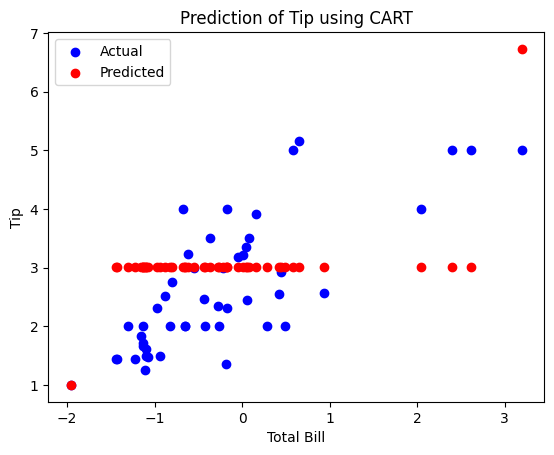

In [22]:
# Make predictions on the entire dataset for visualization
testingSet['predicted_tip'] = testingSet.apply(lambda row: predict(tree, row), axis=1)

print("Mean Square Error : ", mean_squared_error(testingSet['predicted_tip'], testingSet['tip']))

# Plot the regression line
plt.scatter(testingSet['total_bill'], testingSet['tip'], color='blue', label='Actual')
plt.scatter(testingSet['total_bill'], testingSet['predicted_tip'], color='red', label='Predicted')
plt.title('Prediction of Tip using CART')
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.legend()
plt.show()

-----------------------
### CART From sklearn

In [12]:
cart_model = DecisionTreeRegressor()
cart_model.fit(x_train, y_train)

DecisionTreeRegressor()

In [13]:
predicted_y = cart_model.predict(x_test)

In [14]:
print("Mean Square Error : ", mean_squared_error(predicted_y, y_test))

Mean Square Error :  1.1224816326530613


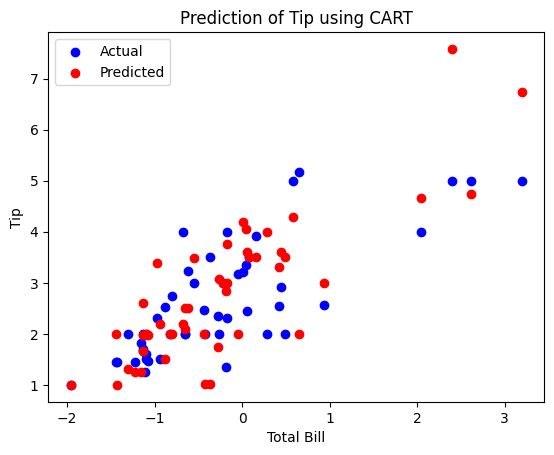

In [18]:
# Plot the regression line
plt.scatter(testingSet['total_bill'], testingSet['tip'], color='blue', label='Actual')
plt.scatter(testingSet['total_bill'], predicted_y, color='red', label='Predicted')
plt.title('Prediction of Tip using CART')
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.legend()
plt.show()

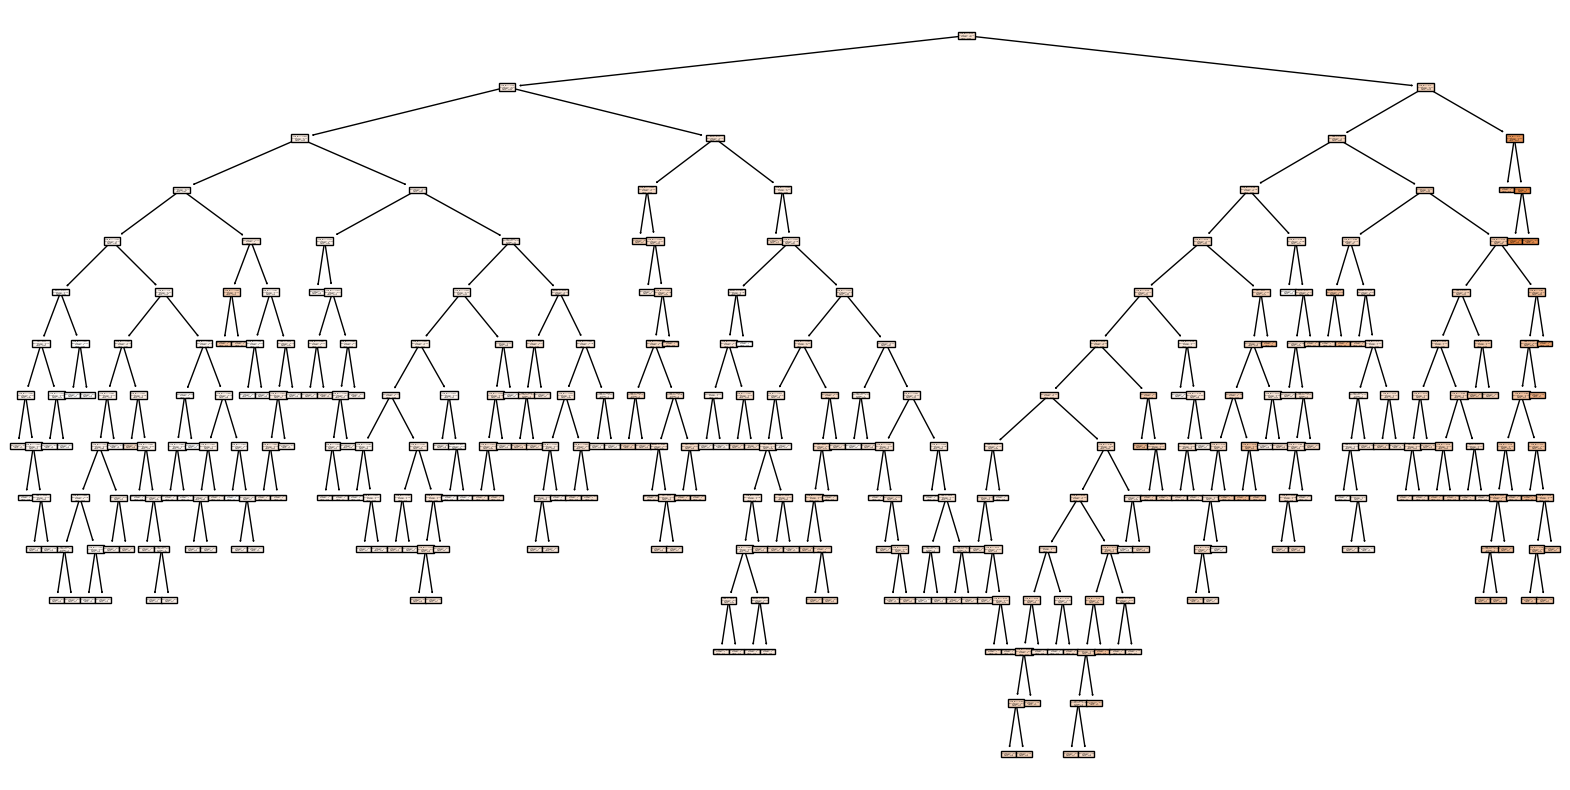

In [17]:
from sklearn import tree
# Visualize the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(cart_model, feature_names=dataSet.columns, filled=True)
plt.show()